In [1]:
%run 'Functions.ipynb'

In [2]:
def hist_terms(terms=None, interval='week', start='1900-01-01', end='2020-01-01'):
    q = Search(index='hep-analysis')[0:0]
    if terms:
        q = q.query('match_phrase', **{'abstracts.value': terms})
    q = q.filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval=interval,
        format='date_optional_time'
    )
    return q.execute().aggregations.group_by_date.buckets

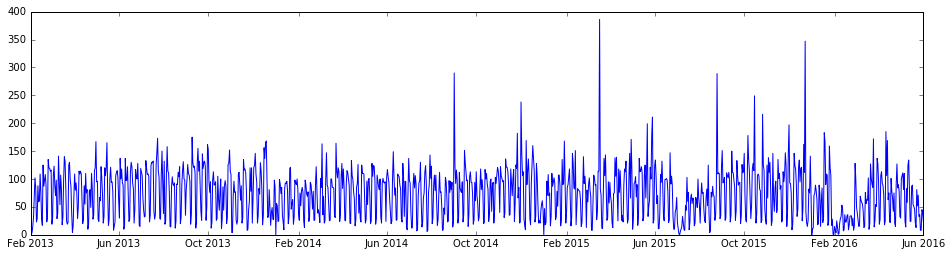

In [84]:
tx, ty = unzip(hist_terms(interval='1d'))
plt.plot(tx, ty)

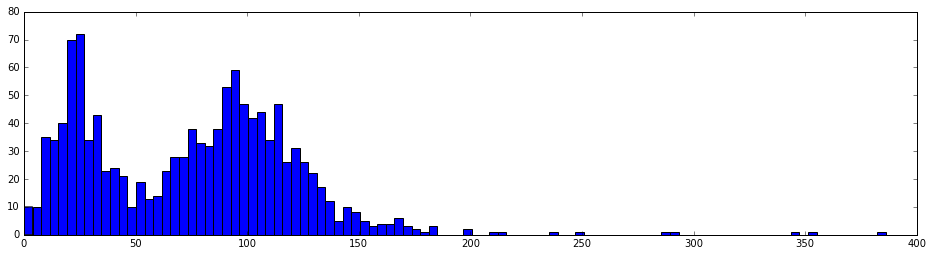

In [85]:
plt.hist(ty, bins=100)
plt.show()

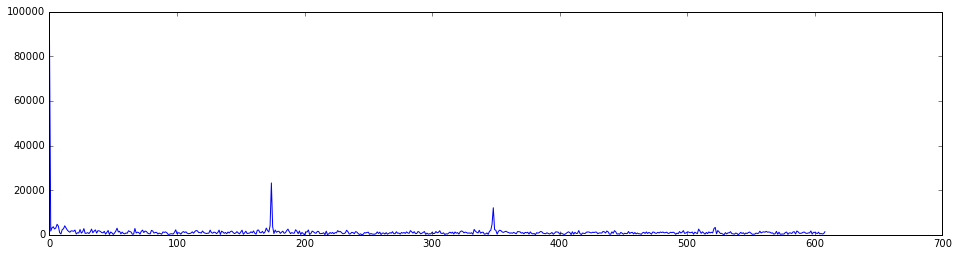

In [86]:
plt.plot(np.abs(np.fft.rfft(ty)))

In [6]:
fft = np.abs(np.fft.rfft(ty))
fft[fft < 12000] = 0

In [7]:
days = (max(tx)-min(tx)).days
days

1216

In [8]:
np.argsort(-fft)[:5]

array([  0, 174, 348, 403, 404])

In [9]:
np.nonzero(fft)

(array([  0, 174, 348]),)

In [10]:
1 / (np.nonzero(fft)[0][1:] / days)

array([ 6.98850575,  3.49425287])

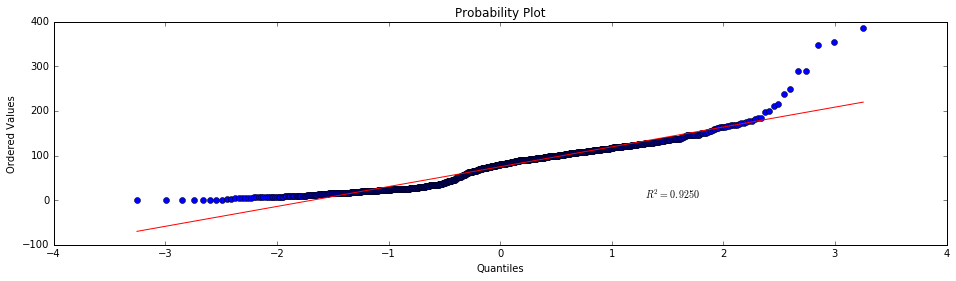

In [12]:
sp.stats.probplot(ty, dist="norm", plot=py)
py.show()

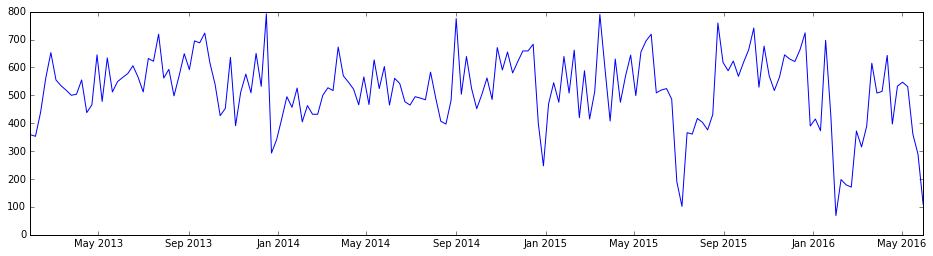

In [13]:
tx, ty = unzip(hist_terms())
plt.plot(tx, ty)

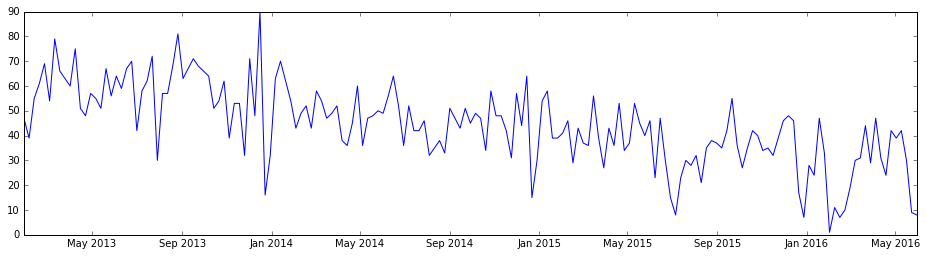

In [14]:
x, y = unzip(hist_terms('galaxy'))
plt.plot(x, y)

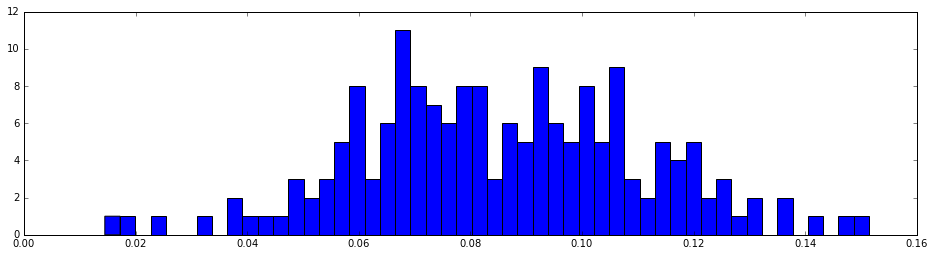

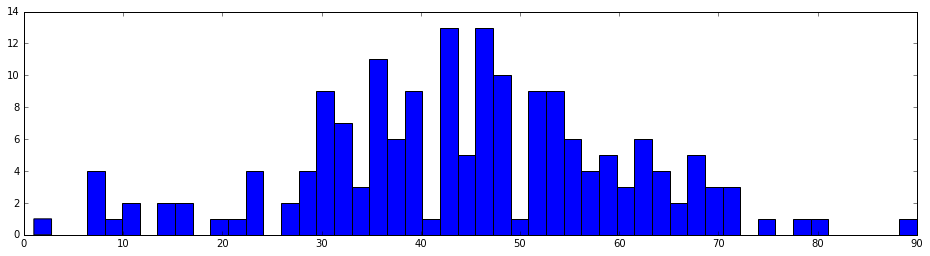

In [15]:
plt.hist(zero_div(y, ty), bins=50)
plt.show()
plt.hist(y, bins=50)
plt.show()

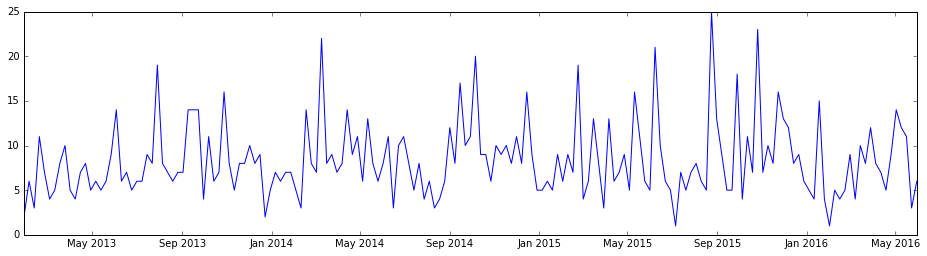

In [16]:
x, y = unzip(hist_terms('laser'))
plt.plot(x, y)

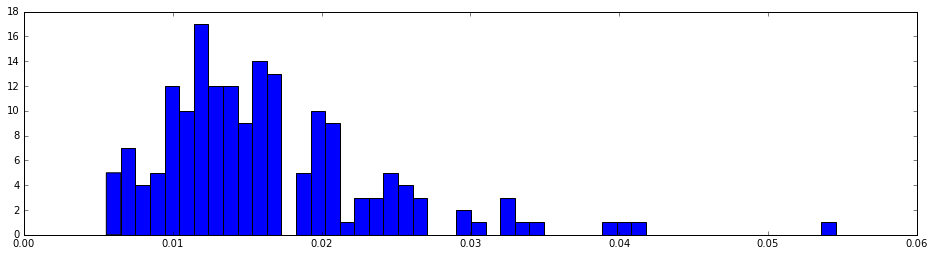

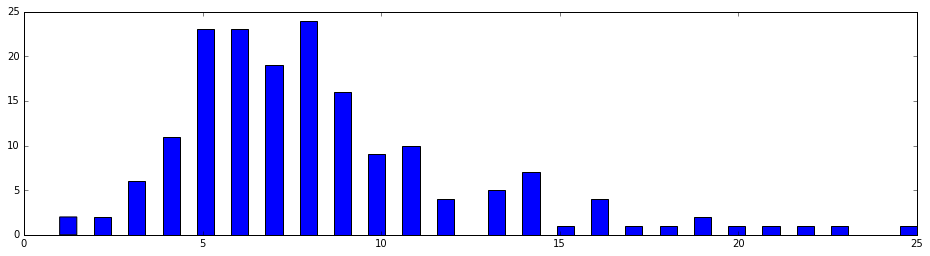

In [17]:
plt.hist(zero_div(y, ty), bins=50)
plt.show()
plt.hist(y, bins=50)
plt.show()

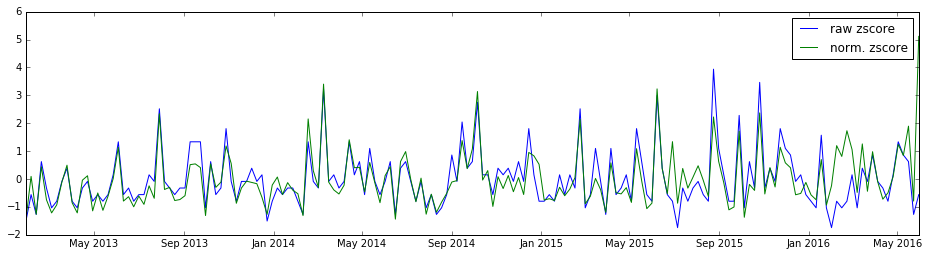

In [18]:
plt.plot(x, sp.stats.zscore(y), label='raw zscore')
plt.plot(x, sp.stats.zscore(zero_div(y, ty)), label='norm. zscore')
plt.legend()

In [19]:
id_week1 = interval_ids('2013-03-01')
id_week2 = interval_ids('2013-03-08')
id_week3 = interval_ids('2013-03-15')
id_week4 = interval_ids('2013-03-22')

In [20]:
terms_week1 = fold_vectors(term_vectors(id_week1, 'abstracts.value'))
terms_week2 = fold_vectors(term_vectors(id_week2, 'abstracts.value'))
terms_week3 = fold_vectors(term_vectors(id_week3, 'abstracts.value'))
terms_week4 = fold_vectors(term_vectors(id_week4, 'abstracts.value'))

In [21]:
terms_week1['higg']

{'doc_freq': 49, 'doc_total': 977, 'term_freq': 454, 'term_total': 7123}

In [22]:
terms_week2['higg']

{'doc_freq': 24, 'doc_total': 961, 'term_freq': 215, 'term_total': 7010}

In [23]:
terms_week3['higg']

{'doc_freq': 25, 'doc_total': 977, 'term_freq': 266, 'term_total': 7123}

In [24]:
terms_week4['higg']

{'doc_freq': 33, 'doc_total': 944, 'term_freq': 256, 'term_total': 6727}

In [25]:
raw = fold_vectors(term_vectors(interval_ids('2013-03-01', days=600), 'abstracts.value'))

In [26]:
selected = {}
for k, v in sorted(raw.items()):
    if v['doc_freq'] >= 25:
        selected[k] = v

In [27]:
len(selected)

19346

In [28]:
def align_origin(ax1, ax2):
    _, y1 = ax1.transData.transform((0, 0))
    _, y2 = ax2.transData.transform((0, 0))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1 - y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny + dy, maxy + dy)

In [29]:
def plot_scores(data, *scores):
    fig, ax1 = plt.subplots()
    for score, label in scores:
        ax1.plot(x, score , label=label)
    plt.legend()
    ax2 = ax1.twinx()
    ax2.fill_between(x, 0, data - np.ones(len(data)) * np.mean(data), facecolor='lightgrey', alpha=0.3)
    align_origin(ax1, ax2)
    plt.show()

In [30]:
spiky = []
for k, v in list(selected.items())[:100]:
    hist = hist_terms(k)
    if len(hist):
        x, y = unzip(hist_terms(k))
        start = np.where(tx == min(x))[0][0]
        end = np.where(tx == max(x))[0][0]
        scoped = ty[start:end+1]
        normalized = zero_div(y, scoped)
        zscore = sp.stats.zscore(normalized)
        chiscore = (normalized - np.mean(normalized)) ** 2 / np.mean(normalized)

        for index in np.where(zscore >= 3)[0]:
            spiky.append((x[index], k, zscore[index], chiscore[index]))

            #plot_scores(normalized, (zscore, 'zscore'), (chiscore * 100, 'chiscore'))

In [31]:
"%f%%" % ((1 - sp.stats.norm.cdf(4)) * 100)

'0.003167%'

In [32]:
len(spiky)

255

In [33]:
trends = {}
for k, v, zscore, chiscore in spiky:
    date = k.strftime("%Y-%m")
    elem = (v, zscore, chiscore)
    if date in trends:
        trends[date].append(elem)
    else:
        trends[date] = [elem]

In [34]:
top_trends = {}
for date, terms in sorted(trends.items()):
    top_trends[date] = [e for e in sorted(terms, key=lambda x: -x[1])]

In [35]:
for date, terms in sorted(top_trends.items()):
    print(date)
    for wordScore in terms:
        print('%s' % wordScore[0])
    print()

2013-01
temperature distribution
xmm
flavor physics

2013-02
mean field model
temperature distribution
can distinguished

2013-03
use radio
cmb lens
disk can
equation one
composition
may serve
warm

2013-04
theory compactify
inventory
inventory
quadrant
use radio

2013-05
pollution
inventory
disk can
flavor physics
approximate one

2013-06
several ten
pollution
carbon oxygen
may serve

2013-07
italy
derivative expansion
several ten
inventory
exponential suppress

2013-08
regulate
warm
approximate one
onset
coax

2013-09
dft
disk can
neighbourhood
heights
emission spectra

2013-10
formation rate sfr
high excite

2013-11
function also
review result

2013-12
approximate one
can distinguished
se
able provide
equation one
dimension operator
result terms
formation rate sfr
bc

2014-01
function well
ways
sample use
structure can

2014-02
empirical model
high excite

2014-03
lens image

2014-04
planck collaboration
neutrino dark
mass scale
temperature distribution

2014-05
heavy ion
einstein m

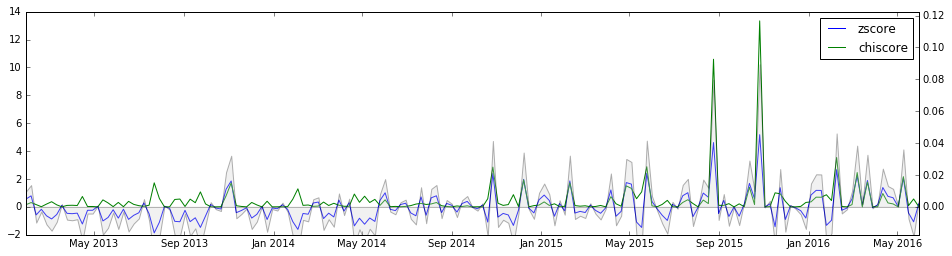

In [43]:
x, y = unzip(hist_terms('neutron'))
y = zero_div(y, ty)
zscore = sp.stats.zscore(y)
chiscore = (y - np.mean(y)) ** 2 / np.mean(y)
plot_scores(y, (zscore, 'zscore'), (chiscore * 100, 'chiscore'))

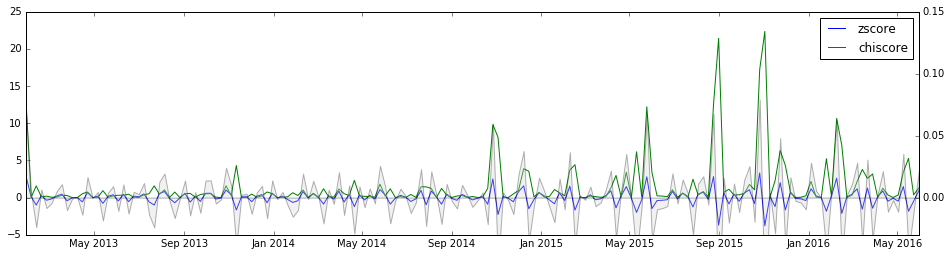

In [59]:
x, y = unzip(hist_terms('neutron'))
y = zero_div(y, ty)
y = np.convolve(y, [1, -1], mode='same')
zscore = sp.stats.zscore(y)
chiscore = (y - np.mean(y)) ** 2 / np.mean(y)
plot_scores(y, (zscore, 'zscore'), (chiscore, 'chiscore'))

In [36]:
def repeat_sides(num, arr):
    arr = np.array(arr)
    left = np.ones(num) * arr[0]
    right = np.ones(num) * arr[-1]
    return np.append(left, np.append(arr, right))

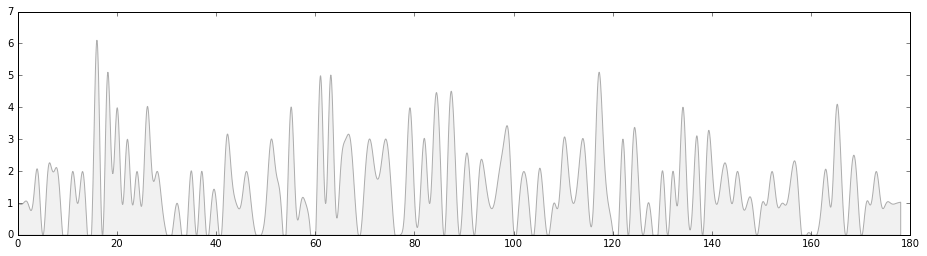

In [37]:
data = repeat_sides(3, y)
inter = sp.interpolate.Rbf(range(len(data)), data)
x_new = np.arange(0, len(data), 0.05)
y_new = inter(x_new)
y_new[y_new < 0] = 0 
#plt.plot(inter, spl(inter))
plt.fill_between(x_new, 0, y_new, facecolor='lightgrey', alpha=0.3)
#plt.plot(data)

In [1]:
import requests
import json

In [3]:
WORD2VEC_URL = 'http://magpie.inspirehep.net/api/word2vec'
headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}

data = {'corpus': 'keywords', 'positive': ['susy,blanc'], 'negative': []}

response = requests.post(WORD2VEC_URL, data=json.dumps(data), headers=headers)
json.loads(response.text)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)